* The objective of this assignments is to build the **Decoder** part of the Transformer architecture.
* We will be using the **PyTorch** framework to implement the following components
  * Decoder Layer that contains
    * Multi-Head Masked Attention (MHMA) Module
    * Multi-Head Cross Attention (MHMA) Module
    * Position-wise Feed Forward Neural Network

  * Implement CLM

* **DO NOT** USE Built-in **TRANSFORMER LAYERS** as it affects the reproducibility.

* You will be given with a configuration file that contains information on various hyperparameters such as embedding dimension, vocabulary size,number heads and so on

* Use ReLU activation function and Stochastic Gradient Descent optimizer
* Here are a list of helpful Pytorch functions (does not mean you have to use all of them) for this subsequent assignments
  * [torch.matmul](https://pytorch.org/docs/stable/generated/torch.matmul.html#torch-matmul)
  * [torch.bmm](https://pytorch.org/docs/stable/generated/torch.bmm.html)
  * torch.swapdims
  * torch.unsqueeze
  * torch.squeeze
  * torch.argmax
  * [torch.Tensor.view](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html)
  * [torch.nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)
  * [torch.nn.Parameter](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)
  * torch.nn.Linear
  * torch.nn.LayerNorm
  * torch.nn.ModuleList
  * torch.nn.Sequential
  * [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
  
* Important: Do not set any global seeds.

* Helpful resources to get started with

 * [Andrej Karpathys Nano GPT](https://github.com/karpathy/nanoGPT)
 * [PyTorch Source code of Transformer Layer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)



In [1]:
import torch
from torch import Tensor

import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.nn.functional import one_hot

import torch.optim as optim

from  pprint import pprint
from yaml import safe_load
import copy
import requests
from io import BytesIO

import matplotlib.pyplot as plt

In [2]:
#do not edit this cell
config_url = "https://raw.githubusercontent.com/Arunprakash-A/LLM-from-scratch-PyTorch/main/config_files/dec_config.yml"
response = requests.get(config_url)
config = response.content.decode("utf-8")
config = safe_load(config)
pprint(config)

{'input': {'batch_size': 10, 'embed_dim': 32, 'seq_len': 8, 'vocab_size': 12},
 'model': {'d_ff': 128,
           'd_model': 32,
           'dk': 4,
           'dq': 4,
           'dv': 4,
           'n_heads': 8,
           'n_layers': 6}}


In [3]:
vocab_size = config['input']['vocab_size']
batch_size = config['input']['batch_size']
seq_len = config['input']['seq_len']
embed_dim = config['input']['embed_dim']
dmodel = embed_dim
dq = torch.tensor(config['model']['dq'])
dk = torch.tensor(config['model']['dk'])
dv = torch.tensor(config['model']['dv'])
heads = torch.tensor(config['model']['n_heads'])
d_ff = config['model']['d_ff']

# Input tokens

* Generate a raw_input ids (without any special tokens appended to it)

* Since we will be using this as label after adding the special  \<start\> token, we use the variable name "label_ids"

* Keep the size of the `label_ids=(bs,seq_len-1)` as we insert a special token ids in the next step

In [4]:
# do not edit this cell
data_url = 'https://github.com/Arunprakash-A/LLM-from-scratch-PyTorch/raw/main/config_files/w2_input_tokens'
r = requests.get(data_url)
label_ids = torch.load(BytesIO(r.content),weights_only=True)
print(label_ids, label_ids.size())

tensor([[ 7,  8,  7,  7,  9,  2,  6],
        [10,  1, 10,  5,  3,  6,  8],
        [ 3,  4,  8,  2, 10, 10, 10],
        [ 4, 10,  1,  3,  4,  9,  7],
        [ 8,  4,  7,  3,  8, 10,  5],
        [ 9,  1,  8,  5,  9,  9, 10],
        [ 7,  3,  8,  2,  5,  1,  5],
        [ 3,  3,  2,  1,  4,  1,  1],
        [10,  9,  9,  9,  6,  9,  2],
        [ 3,  6,  6,  3,  5,  4,  5]]) torch.Size([10, 7])


* Let the first token_id be be a special `[start]` token (mapped to integer 0)
* If label_ids=$\begin{bmatrix}1&2\\3&4 \end{bmatrix}$, then we modify it as $\begin{bmatrix}0&1&2\\0&3&4 \end{bmatrix}$

In [5]:
#token_ids = None # the first column of token_ids should be zeros and the rest of the columns come from label_ids

# Insert a special [start] token (ID = 0) at the beginning of label_ids
start_token = torch.zeros(label_ids.shape[0], 1, dtype=torch.long)
token_ids = torch.cat((start_token, label_ids), dim=1)

print(token_ids, token_ids.size())

tensor([[ 0,  7,  8,  7,  7,  9,  2,  6],
        [ 0, 10,  1, 10,  5,  3,  6,  8],
        [ 0,  3,  4,  8,  2, 10, 10, 10],
        [ 0,  4, 10,  1,  3,  4,  9,  7],
        [ 0,  8,  4,  7,  3,  8, 10,  5],
        [ 0,  9,  1,  8,  5,  9,  9, 10],
        [ 0,  7,  3,  8,  2,  5,  1,  5],
        [ 0,  3,  3,  2,  1,  4,  1,  1],
        [ 0, 10,  9,  9,  9,  6,  9,  2],
        [ 0,  3,  6,  6,  3,  5,  4,  5]]) torch.Size([10, 8])


# Implement the following components of a decoder layer

 * Multi-head Masked Attention (MHMA)
 * Multi-head Cross Attention (MHCA)
 * Postion-wise FFN

* Randomly initialize the parameters using normal distribution with the following seed values
  * $W_Q:$(seed=43)
  * $W_K:$(seed=44)
  * $W_V:$(seed=45)
  * $W_O:$(seed=46)

* Remember that, Multi-head cross atention takes two represnetation. One is the encoder output and the other one is the output from masked attetnion sub-layer.

* However, in this assignment, we will fix it to a random matrix.

MHMA

* By default, `mask=None`. Therefore, create and apply the mask while computing the attention scores


In [6]:
class MHMA(nn.Module):
    def __init__(self, dmodel, dq, dk, dv, heads, mask=None):
        super(MHMA, self).__init__()

        self.dmodel = dmodel
        self.dq = dq
        self.dk = dk
        self.dv = dv
        self.heads = heads

        # Initialize weights for Q, K, V, and output using random seeds
        torch.manual_seed(43)
        self.WQ = nn.Parameter(torch.randn(dq * heads, dmodel))

        torch.manual_seed(44)
        self.WK = nn.Parameter(torch.randn(dk * heads, dmodel))

        torch.manual_seed(45)
        self.WV = nn.Parameter(torch.randn(dv * heads, dmodel))

        torch.manual_seed(46)
        self.WO = nn.Parameter(torch.randn(dmodel, dv * heads))

        self.mask = mask

    def forward(self, x):
        # Linear transformations for Q, K, V
        Q = torch.matmul(x, self.WQ.T)  # (batch_size, seq_len, dq * heads)
        K = torch.matmul(x, self.WK.T)  # (batch_size, seq_len, dk * heads)
        V = torch.matmul(x, self.WV.T)  # (batch_size, seq_len, dv * heads)

        # Reshape Q, K, V for multi-head computation
        batch_size = Q.shape[0]
        seq_len = Q.shape[1]

        Q = Q.view(batch_size, seq_len, self.heads, self.dq).transpose(1, 2)  # (batch_size, heads, seq_len, dq)
        K = K.view(batch_size, seq_len, self.heads, self.dk).transpose(1, 2)  # (batch_size, heads, seq_len, dk)
        V = V.view(batch_size, seq_len, self.heads, self.dv).transpose(1, 2)  # (batch_size, heads, seq_len, dv)

        # Scaled dot-product attention
        dk = torch.tensor(self.dk, dtype=torch.float32)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(dk)  # (batch_size, heads, seq_len, seq_len)

        # Apply mask (if mask not provided)
        if self.mask is None:
            self.mask = torch.triu(torch.ones((seq_len, seq_len)), diagonal=1).to(scores.device)
            self.mask = self.mask == 1  # Convert to boolean mask

        scores = scores.masked_fill(self.mask.unsqueeze(0).unsqueeze(0), float('-inf'))
        #print(scores) for debugging
        # Apply softmax to obtain attention weights
        attn_weights = F.softmax(scores, dim=-1)  # (batch_size, heads, seq_len, seq_len)

        # Compute output
        out = torch.matmul(attn_weights, V)  # (batch_size, heads, seq_len, dv)

        # Concatenate heads
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, self.heads * self.dv)

        # Final linear transformation
        out = torch.matmul(out, self.WO.T)  # (batch_size, seq_len, dmodel)
        # print("Size of output from Mask Attention layer is\n", out.size())for debugging
        return out

MHCA

In [7]:
class MHCA(nn.Module):
    def __init__(self, dmodel, dq, dk, dv, heads):
        super(MHCA, self).__init__()

        self.dmodel = dmodel
        self.dq = dq
        self.dk = dk
        self.dv = dv
        self.heads = heads

        # Initialize weights for Q, K, V, and output using the specified seeds
        torch.manual_seed(43)
        self.WQ = nn.Parameter(torch.randn(dq * heads, dmodel))

        torch.manual_seed(44)
        self.WK = nn.Parameter(torch.randn(dk * heads, dmodel))

        torch.manual_seed(45)
        self.WV = nn.Parameter(torch.randn(dv * heads, dmodel))

        torch.manual_seed(46)
        self.WO = nn.Parameter(torch.randn(dmodel, dv * heads))

    def forward(self, query, key, value):
        # Query is the output from the masked attention sub-layer
        # Key and Value come from the encoder output (which is fixed to a random matrix here)

        # Linear transformations for Q, K, V
        Q = torch.matmul(query, self.WQ.T)  # (batch_size, seq_len, dq * heads)
        K = torch.matmul(key, self.WK.T)    # (batch_size, seq_len, dk * heads)
        V = torch.matmul(value, self.WV.T)  # (batch_size, seq_len, dv * heads)

        # Reshape Q, K, V for multi-head computation
        batch_size = Q.shape[0]
        seq_len = Q.shape[1]

        Q = Q.view(batch_size, seq_len, self.heads, self.dq).transpose(1, 2)  # (batch_size, heads, seq_len, dq)
        K = K.view(batch_size, seq_len, self.heads, self.dk).transpose(1, 2)  # (batch_size, heads, seq_len, dk)
        V = V.view(batch_size, seq_len, self.heads, self.dv).transpose(1, 2)  # (batch_size, heads, seq_len, dv)

        # Scaled dot-product attention
        dk = torch.tensor(self.dk, dtype=torch.float32)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(dk)  # (batch_size, heads, seq_len, seq_len)
        attn_weights = F.softmax(scores, dim=-1)

        # Compute output
        out = torch.matmul(attn_weights, V)  # (batch_size, heads, seq_len, dv)

        # Concatenate heads
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, self.heads * self.dv)

        # Final linear transformation
        out = torch.matmul(out, self.WO.T)  # (batch_size, seq_len, dmodel)
        #print("Size of output from Cross Attention layer is\n", out.size())for debugging
        return out


* Implement the FFN and OutputLayer modules (same as the one you implemented for encoder)

In [8]:
class FFN(nn.Module):
    def __init__(self, dmodel, d_ff):
        super(FFN, self).__init__()

        # First linear layer maps dmodel -> d_ff
        self.linear1 = nn.Linear(dmodel, d_ff)

        # Second linear layer maps d_ff -> dmodel
        self.linear2 = nn.Linear(d_ff, dmodel)

    def forward(self, x):
        # First linear layer followed by ReLU activation
        x = F.relu(self.linear1(x))

        # Second linear layer
        out = self.linear2(x)
        #print("Size of output from FFN layer is\n", out.size())for debugging
        return out

In [9]:
class OutputLayer(nn.Module):
    def __init__(self, dmodel, vocab_size):
        super(OutputLayer, self).__init__()

        # Linear layer mapping dmodel -> vocab_size to predict token IDs
        self.linear = nn.Linear(dmodel, vocab_size)

    def forward(self, x):
        # Apply linear layer to project to vocab size
        out = self.linear(x)
        #print("Size of output from Output layer is\n", out.size())for debugging
        return out

* Implement the final decoder layer.

In [10]:
class DecoderLayer(nn.Module):
    def __init__(self, dmodel, dq, dk, dv, d_ff, heads, mask=None):
        super(DecoderLayer, self).__init__()
        # Multi-head Masked Attention sub-layer
        self.mhma = MHMA(dmodel, dq, dk, dv, heads, mask=mask)
        # Multi-head Cross Attention sub-layer
        self.mhca = MHCA(dmodel, dq, dk, dv, heads)
        # Position-wise Feed Forward Network
        self.ffn = FFN(dmodel, d_ff)

        # Layer normalization for each sub-layer
        self.layer_norm_mhma = nn.LayerNorm(dmodel)
        self.layer_norm_mhca = nn.LayerNorm(dmodel)
        self.layer_norm_ffn = nn.LayerNorm(dmodel)

    def forward(self, x, encoder_output):
        # Multi-head Masked Self-Attention with residual connection and layer normalization
        mhma_output = self.mhma(x)
        x = self.layer_norm_mhma(x + mhma_output)

        # Multi-head Cross Attention with residual connection and layer normalization
        mhca_output = self.mhca(x, encoder_output, encoder_output)
        x = self.layer_norm_mhca(x + mhca_output)

        # Feed Forward Network with residual connection and layer normalization
        ffn_output = self.ffn(x)
        out = self.layer_norm_ffn(x + ffn_output)
        #print("Size of output from the Decoder layer is\n", out.size())for debugging
        return out


* Create an embedding layer that takes in token_ids and return embeddings for the token_ids

 * Use seed value: 70

In [11]:
class Embed(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(Embed, self).__init__()

        # Set the random seed for reproducibility
        torch.manual_seed(70)

        # Initialize the embedding layer
        self.embed = nn.Embedding(vocab_size, embed_dim)

    def forward(self, x):
        # Lookup the embeddings for the token_ids
        out = self.embed(x)
        #print("Size of output from Embedding layer is\n", out.size())for debugging
        return out


# Decoder

 * Implement the decoder that has `num_layers` decoder layers

In [12]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, dmodel, dq, dk, dv, d_ff, heads, mask=None, num_layers=1):
        super(Decoder, self).__init__()

        # Embedding layer for the target token IDs
        self.embed_lookup = Embed(vocab_size, dmodel)

        decoder_layer = DecoderLayer(dmodel, dq, dk, dv, d_ff, heads, mask)

        # Stack of decoder layers
        self.dec_layers = nn.ModuleList([copy.deepcopy(decoder_layer) for _ in range(num_layers)])

        # Output layer to project the decoder output to the vocabulary size
        self.output_layer = OutputLayer(dmodel, vocab_size)

    def forward(self, enc_rep, tar_token_ids):
        # Get embeddings for the target token IDs
        x = self.embed_lookup(tar_token_ids)

        # Pass through each decoder layer
        for dec_layer in self.dec_layers:
            x = dec_layer(x, enc_rep)

        # Final output layer to get the logits for the vocabulary
        out = self.output_layer(x)
        #print("Size of the final output from DECODER is\n", out.size())for debugging
        return out

* Representation from encoder

 * Since all the decoder layers require the representation from the encoder to compute cross attention, we are going to feed in the random values (Note, it does not require gradient during training)

In [13]:
# do not edit this
enc_rep = torch.randn(size=(batch_size,seq_len,embed_dim),generator=torch.random.manual_seed(10))
print(enc_rep.size())

torch.Size([10, 8, 32])


# Instantiate the model

In [14]:
model = Decoder(vocab_size,dmodel,dq,dk,dv,d_ff,heads,mask=None)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [16]:
import matplotlib.pyplot as plt

def train(enc_rep, tar_token_ids, label_ids, epochs=1000):
    loss_trace = []
    for epoch in range(epochs):
        out = model(enc_rep, tar_token_ids)
        out = out.view(-1, vocab_size)
        target = tar_token_ids.view(-1)

        # Compute loss
        loss = criterion(out, target.long())
        loss_trace.append(loss.item())  # Store the loss value for visualization

        # Print loss every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'Loss in epoch - {epoch + 1} is {loss.item()}')

        # Backpropagation
        loss.backward()

        # Update parameters
        optimizer.step()
        optimizer.zero_grad()

    # Plot the loss curve
    plt.plot(range(epochs), loss_trace, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()
    plt.grid()
    plt.show()

* Train the model for 1000 epochs

<ipython-input-6-b5d33902253e>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dk = torch.tensor(self.dk, dtype=torch.float32)
<ipython-input-7-9b822234539e>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dk = torch.tensor(self.dk, dtype=torch.float32)


Loss in epoch - 100 is 1.9854390621185303
Loss in epoch - 200 is 1.637133240699768
Loss in epoch - 300 is 1.3524713516235352
Loss in epoch - 400 is 1.1218345165252686
Loss in epoch - 500 is 0.9193586111068726
Loss in epoch - 600 is 0.7540795207023621
Loss in epoch - 700 is 0.5999165773391724
Loss in epoch - 800 is 0.47275200486183167
Loss in epoch - 900 is 0.36953356862068176
Loss in epoch - 1000 is 0.2794091999530792


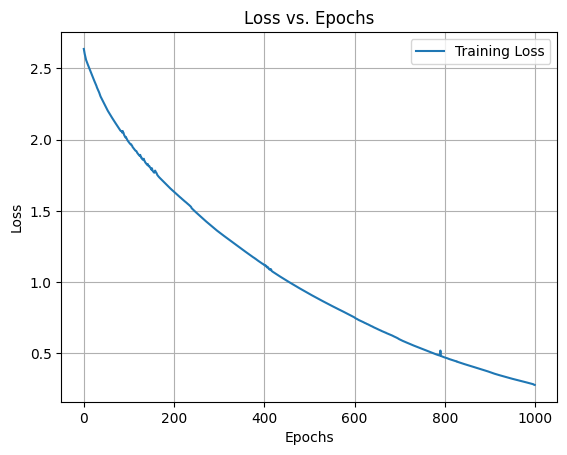

In [17]:
train(enc_rep,token_ids,label_ids,1000)

In [18]:
with torch.inference_mode():
  predictions = torch.argmax(model(enc_rep,token_ids),dim=-1)

<ipython-input-6-b5d33902253e>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dk = torch.tensor(self.dk, dtype=torch.float32)
<ipython-input-7-9b822234539e>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dk = torch.tensor(self.dk, dtype=torch.float32)


* The loss will be around 0.17 after 1000 epochs

In [19]:
# number of correct predictions
print(torch.count_nonzero(label_ids==predictions[:,1:]))

tensor(68)


* THe number of correct predictions is close to 66

In [20]:
# Initialize total_num_parameters to zero
total_num_parameters = 0

# Loop through all named parameters in the model
for name, parameter in model.named_parameters():
    # Get the number of elements in the parameter tensor
    num_params = parameter.numel()
    # Print the parameter name and number of elements
    print(f"Parameter name: {name}, Number of parameters: {num_params}")
    # Add this to the total count
    total_num_parameters += num_params

# Print the total result
print('Total number of parameters in the model, including the embedding layer, is:', total_num_parameters)


Parameter name: embed_lookup.embed.weight, Number of parameters: 384
Parameter name: dec_layers.0.mhma.WQ, Number of parameters: 1024
Parameter name: dec_layers.0.mhma.WK, Number of parameters: 1024
Parameter name: dec_layers.0.mhma.WV, Number of parameters: 1024
Parameter name: dec_layers.0.mhma.WO, Number of parameters: 1024
Parameter name: dec_layers.0.mhca.WQ, Number of parameters: 1024
Parameter name: dec_layers.0.mhca.WK, Number of parameters: 1024
Parameter name: dec_layers.0.mhca.WV, Number of parameters: 1024
Parameter name: dec_layers.0.mhca.WO, Number of parameters: 1024
Parameter name: dec_layers.0.ffn.linear1.weight, Number of parameters: 4096
Parameter name: dec_layers.0.ffn.linear1.bias, Number of parameters: 128
Parameter name: dec_layers.0.ffn.linear2.weight, Number of parameters: 4096
Parameter name: dec_layers.0.ffn.linear2.bias, Number of parameters: 32
Parameter name: dec_layers.0.layer_norm_mhma.weight, Number of parameters: 32
Parameter name: dec_layers.0.layer_n